In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cub.experiment import CUB

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
# EXP_DIR = 'runs/CUB/joint_elbo/laplace_categorical/GM_MNIST_2022_01_19_19_48_02_758796/'
EXP_DIR = 'runs/CUB/poe/laplace_categorical/wrew/'
# EXP_DIR = 'runs/CUB/moe/laplace_categorical/GM_MNIST_2022_01_19_19_53_53_870438/'

In [3]:
flags = torch.load(os.path.join(EXP_DIR, 'flags.rar'))

In [4]:
exp = CUB(flags)

dict_keys(['real', 'random', '', 'cub_img', 'cub_txt', 'cub_img_cub_txt'])


In [5]:
vae = exp.mm_vae

In [6]:
vae.load_state_dict(torch.load(os.path.join(EXP_DIR, 'checkpoints/0049/mm_vae')))

<All keys matched successfully>

In [7]:
CUB_test = exp.dataset_test
test_loader = torch.utils.data.DataLoader(CUB_test, batch_size=200, shuffle=True)

In [8]:
with torch.no_grad():
    for (data, idx) in test_loader:
        for key in data.keys():
            data[key] = data[key].to(flags.device)
        results = vae(data)
        x_rec = results['rec']
        x_rec = [x_rec['cub_img'].loc, x_rec['cub_txt'].probs.argmax(dim=1).reshape(x_rec['cub_img'].loc.shape[0], -1)]
        break

In [9]:
from poisevae.utils import NN_lookup
dist, idx_h = NN_lookup(x_rec[0], data['cub_img'])
imgs_h = [CUB_test.CUBimg.dataset[int(idx[j]) // 10][0] for j in idx_h]
imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]

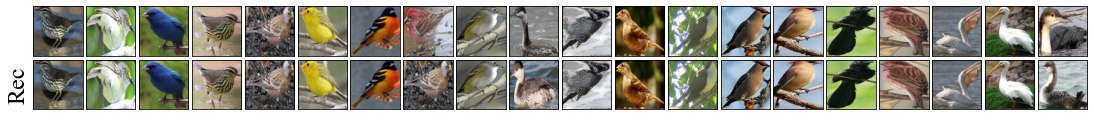

In [10]:
ncols = min(len(imgs_h), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.permute(1, 2, 0))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(os.path.join(PATH, 'CUBImgRec.pdf'), dpi=300)

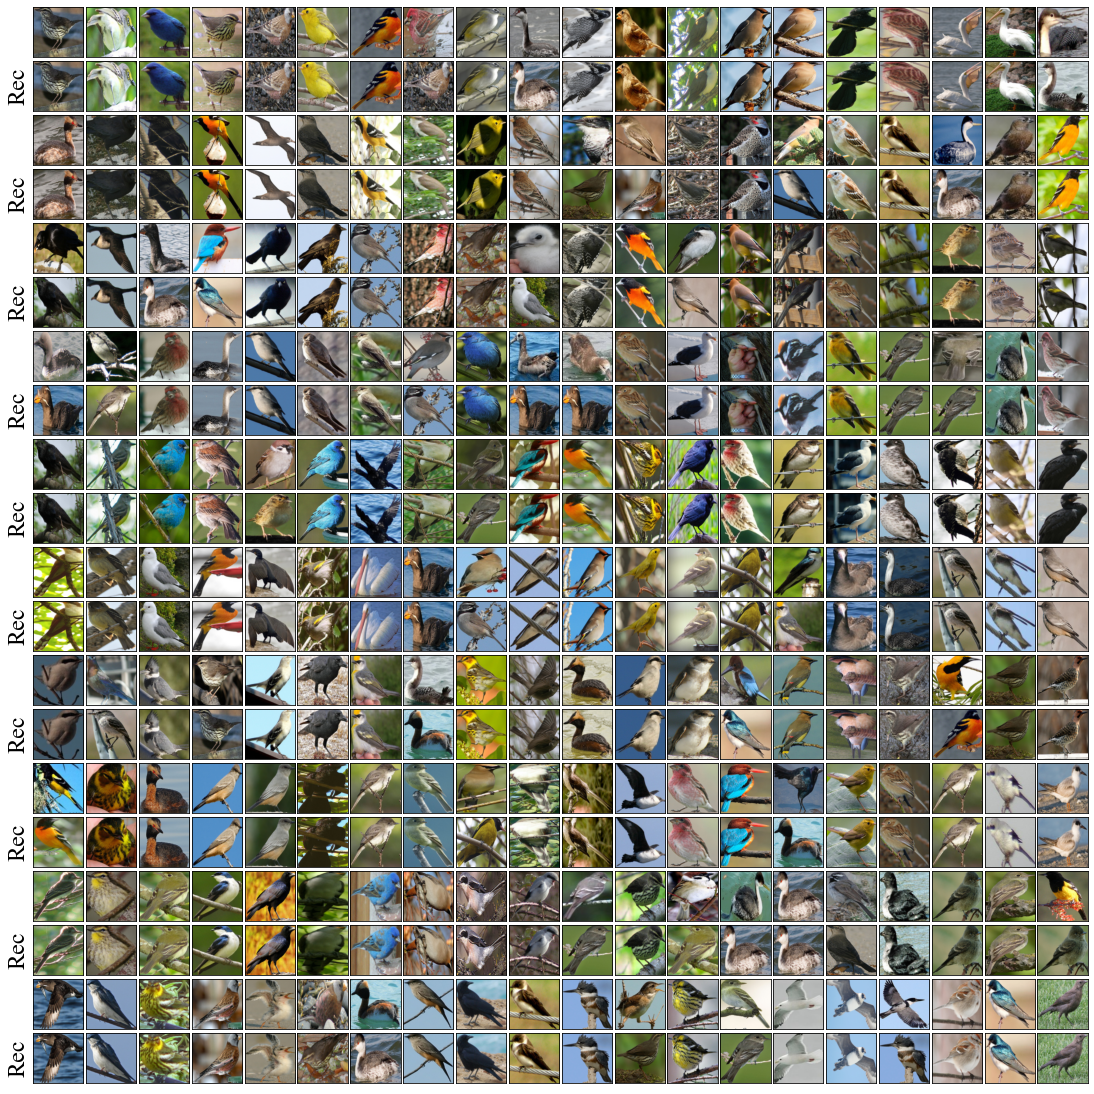

In [11]:
ncols = min(len(imgs_h), 20)
nrows = 2 * int(np.floor(len(imgs_h) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.permute(1, 2, 0))
        ax[j+i//20*2, i%20].set_xticks([])
        ax[j+i//20*2, i%20].set_yticks([])
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(os.path.join(PATH, 'CUBImgRecExtra.pdf'), dpi=300)

In [12]:
sents_h = []
sents_emb = x_rec[1]
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

sents = []
for i, sent_h in enumerate(sents_h):
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    sents.append(' '.join(sent))

In [13]:
for sent, sent_h in zip(sents, sents_h):
    print('     ', sent)
    print('Rec: ', sent_h)

      this bird has a speckled belly and breast with a short pointy bill .
Rec:  this bird has a speckled belly and breast with a short pointy bill .
      this bird is white with grey and has a long , pointy beak .
Rec:  this bird is white with grey and has a long , pointy beak .
      this blue bird has a long tail and a white short thick beak .
Rec:  this blue bird has a long tail and a white thick short beak .
      this bird has a grey back , a white and black spotted belly and breast and a yellow eyebrow .
Rec:  this bird has a grey back , a white and brown spotted belly and breast and light yellow eyebrow .
      a sharply triangular yellow bill with a dark grey crown and a light grey head , reddish brown abdomen , dark brown wings with white wingbars .
Rec:  a small orange billed bird with a dark grey crown and a light brown head , speckled brown abdomen , dark brown wings with white wingbars .
      this particular bird has a belly that is yellow with brown secondaries .
Rec: 

In [14]:
# with open(os.path.join(PATH, 'CUBTxtRec.txt'), 'w') as file:
#     for sent, sent_h in zip(sents, sents_h):
#         file.write('Ref: ' + sent + '\n')
#         file.write('Rec: ' + sent_h + '\n')